# Transfer Learning 
We use networks pre-trained on a large data set to identify features in a smaller but similar dataset. We then build only the additional layers required for classification

## Imports

In [1]:
import pandas as pd
import numpy as np
import os
#os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
import tensorflow as tf
np.random.seed(42)
tf.set_random_seed(42)

import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNetV2, ResNet50, InceptionV3
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt

## Build a model
We use MobileNet, a residual network designed for mobile applications, then attach a new classifier to it.

In [3]:
base_model=MobileNetV2(weights='imagenet', #model MobileNetV2 has been trained on imagenet dataset
                       include_top=False, # drop the classifier
                       pooling='avg') # global average pooling applied to last block, output is 2D
x=base_model.output
#x=Dense(1024,activation='relu')(x) #we add dense layers for our own classification problem
#x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W1008 19:25:40.549153 139940760991488 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1008 19:25:40.549911 139940760991488 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 19:25:40.554862 139940760991488 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend

In [4]:
# Instantiate the model and specify input and output layers
model=Model(inputs=base_model.input,outputs=preds)

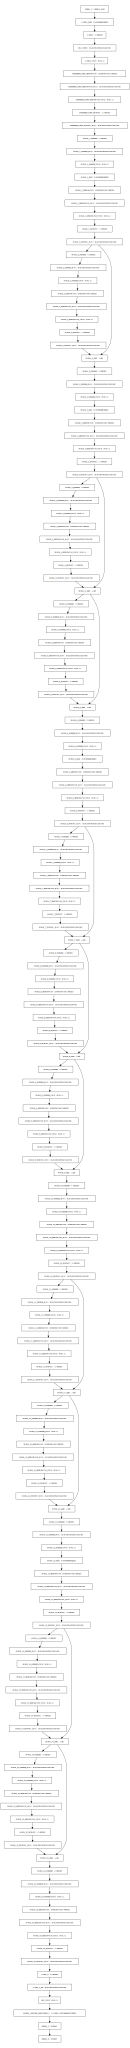

In [5]:
# Plot model graph
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
# lock the pre-trained layers
for layer in model.layers[:-2]:
    layer.trainable=False
for layer in model.layers[-2:]:
    layer.trainable=True

## Use an image generator
The image generator will build out a dataset for processing from a directory structure where the directory names are classes for the picture files within

In [7]:
from PIL import Image
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
test_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./train/', # path to the training dataset
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=8,
                                                 class_mode='categorical',
                                                 shuffle=True)
test_generator=test_datagen.flow_from_directory('./test/', # path to the validation dataset
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=8,
                                                 class_mode='categorical',
                                                 shuffle=True)

Found 149 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


## Build the computation graph
Keras is a static framework. The graph is compiled before computation. We specify:
- Optimizer
- Loss function
- Metrics to track

In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Categorical cross entropy loss
# Accuracy metric

W1008 19:25:50.227783 139940760991488 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



## Train the model
We require:
- training data, from the training generator
- validation data, from the test generator
- number of epochs (i.e. iterations through all dataset)
- steps per epoch, typically the number of samples / batch size
- validation steps per epoch

In [9]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=test_generator.n//test_generator.batch_size
print (step_size_train, step_size_val)

18 1


In [10]:
history=model.fit_generator(generator=train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=step_size_train,
                            validation_steps=step_size_val,
                            epochs=20)

W1008 19:25:50.415509 139940760991488 deprecation.py:323] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
18/18 [==============================] - 8s 419ms/step - loss: 1.2930 - acc: 0.4792 - val_loss: 0.6250 - val_acc: 0.7500
Epoch 2/20
18/18 [==============================] - 4s 248ms/step - loss: 0.5928 - acc: 0.7865 - val_loss: 1.1929 - val_acc: 0.5714
Epoch 3/20
18/18 [==============================] - 5s 293ms/step - loss: 0.4743 - acc: 0.8431 - val_loss: 0.7005 - val_acc: 0.6250
Epoch 4/20
18/18 [==============================] - 6s 316ms/step - loss: 0.4462 - acc: 0.8044 - val_loss: 1.4770 - val_acc: 0.4286
Epoch 5/20
18/18 [==============================] - 6s 329ms/step - loss: 0.3539 - acc: 0.8531 - val_loss: 1.2217 - val_acc: 0.5000
Epoch 6/20
18/18 [==============================] - 5s 287ms/step - loss: 0.2609 - acc: 0.9096 - val_loss: 1.0172 - val_acc: 0.5714
Epoch 7/20
18/18 [==============================] - 5s 279ms/step - loss: 0.2852 - acc: 0.9235 - val_loss: 1.7738 - val_acc: 0.5000
Epoch 8/20
18/18 [==============================] - 5s 285ms/step - loss: 0.

In [11]:
model.save("mobilenetv2.h5")

## Plot accuracy and loss
Note that the last loss or accuracy value is not always the best one.
Keras offers checkpointing to save the best model in progress - more on that later.
Also note that the more complex network is not always the best one.

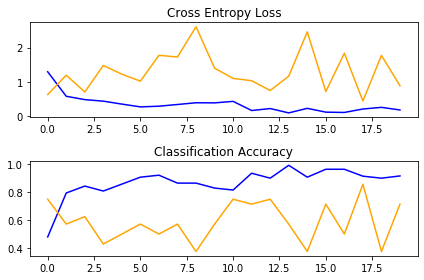

In [12]:
# plot loss
plt.subplot(2,1,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.title('Cross Entropy Loss')
# plot accuracy
plt.subplot(2,1,2)
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')
plt.title('Classification Accuracy')
# save plot to file
filename = 'mobilenet'
plt.savefig(filename + '_plot.png')
plt.tight_layout()
plt.show()
plt.close()



In [13]:
# now try with Inception network

In [14]:
base_model=InceptionV3(weights='imagenet',
                       pooling='avg',
                       include_top=False) #imports the InceptionV3 model and discards the classifier
for layer in base_model.layers:
            layer.trainable = False # locks the base model layers
x=base_model.output
x=Dense(512,activation='relu')(x) #dense layer 1
preds=Dense(3,activation='softmax')(x) #final layer with softmax activation
# Instantiate the model and specify input and output layers
model=Model(inputs=base_model.input,outputs=preds)

W1008 19:27:46.985403 139940760991488 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1008 19:27:47.658649 139940760991488 deprecation_wrapper.py:119] From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



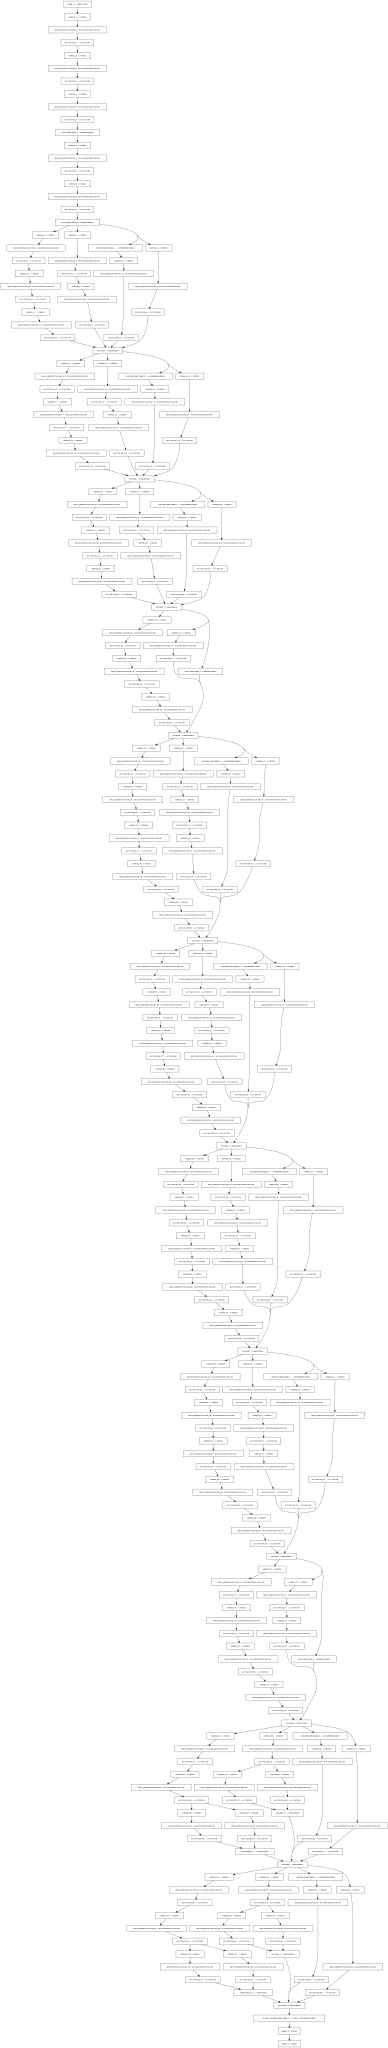

In [15]:
# Plot model graph
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [16]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# Categorical cross entropy loss
# Accuracy metric

In [17]:
step_size_train=train_generator.n//train_generator.batch_size
step_size_val=test_generator.n//test_generator.batch_size
print (step_size_train, step_size_val)

history=model.fit_generator(generator=train_generator,
                            validation_data=test_generator,
                            steps_per_epoch=step_size_train,
                            validation_steps=step_size_val,
                            epochs=20)

18 1
Epoch 1/20
18/18 [==============================] - 10s 531ms/step - loss: 1.6328 - acc: 0.3819 - val_loss: 0.6974 - val_acc: 0.5714
Epoch 2/20
18/18 [==============================] - 4s 221ms/step - loss: 0.8415 - acc: 0.5988 - val_loss: 0.9959 - val_acc: 0.5000
Epoch 3/20
18/18 [==============================] - 5s 294ms/step - loss: 0.7441 - acc: 0.6436 - val_loss: 1.2182 - val_acc: 0.2857
Epoch 4/20
18/18 [==============================] - 5s 292ms/step - loss: 0.6118 - acc: 0.7349 - val_loss: 1.3179 - val_acc: 0.5000
Epoch 5/20
18/18 [==============================] - 5s 304ms/step - loss: 0.6354 - acc: 0.7587 - val_loss: 1.8228 - val_acc: 0.7143
Epoch 6/20
18/18 [==============================] - 6s 311ms/step - loss: 0.6119 - acc: 0.7388 - val_loss: 0.6672 - val_acc: 0.6250
Epoch 7/20
18/18 [==============================] - 6s 318ms/step - loss: 0.5651 - acc: 0.7597 - val_loss: 2.3307 - val_acc: 0.4286
Epoch 8/20
18/18 [==============================] - 6s 329ms/step - lo

In [18]:
model.save("inceptionv3.h5")

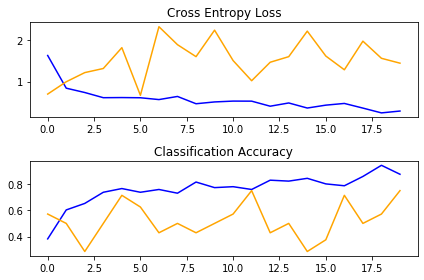

In [19]:
# plot loss
plt.subplot(2,1,1)
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')
plt.title('Cross Entropy Loss')
# plot accuracy
plt.subplot(2,1,2)
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='orange', label='test')
plt.title('Classification Accuracy')
# save plot to file
filename = 'inceptionv3'
plt.savefig(filename + '_plot.png')
plt.tight_layout()
plt.show()
plt.close()